In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

In [2]:
def load_fico(path="./", missing_strategy="drop"):
    data = pd.read_csv(path + "/fico/heloc_dataset_v1.csv")
    meta_info = json.load(open(path + "/fico/data_types.json"))
    meta_info.pop("RiskPerformance")

    ## remove samples with all the values == -9
    rem_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) == 23)[0]
    keep_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) < 23)[0]
    data_rem9 = data.iloc[keep_sample_idx]

    ## dummy for -7, -8, -9
    sample_size = data_rem9.shape[0]
    dummy_data = pd.DataFrame(index = data_rem9.index)
    for i in np.where(np.sum(data_rem9 == -9, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -9)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-9"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-9":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -8, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -8)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-8"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-8":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -7, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -7)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-7"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-7":{"type": "categorical"}})

    meta_info.update({"RiskPerformance":{"type": "target"}})
    final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)
    x, y = final_data.iloc[:,1:].values, final_data.iloc[:,[0]].values
    return x, y, "Classification", meta_info

def load_classification_data(name):
    data_path = '.'
    func_dict = {'fico':load_fico}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_(data_path, missing_strategy="impute")
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                enc = OrdinalEncoder()
                enc.fit(y)
                y = enc.transform(y)
                meta_info[key]['values'] = enc.categories_[0].tolist()
            elif item['type'] == 'categorical':
                enc = OrdinalEncoder()
                xx[:,[i]] = enc.fit_transform(x[:,[i]])
                meta_info[key]['values'] = []
                for item in enc.categories_[0].tolist():
                    try:
                        if item == int(item):
                            meta_info[key]['values'].append(str(int(item)))
                        else:
                            meta_info[key]['values'].append(str(item))
                    except ValueError:
                        meta_info[key]['values'].append(str(item))
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, stratify=y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info
    return wrapper

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

In [4]:
random_state = 0
data_loader = load_classification_data("fico")
train_x, test_x, train_y, test_y, task_type, meta_info = data_loader(random_state)

In [5]:
meta_info.keys()

dict_keys(['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance', 'ExternalRiskEstimate_D-9', 'MSinceOldestTradeOpen_D-8', 'MSinceMostRecentDelq_D-8', 'MSinceMostRecentInqexcl7days_D-8', 'NetFractionRevolvingBurden_D-8', 'NetFractionInstallBurden_D-8', 'NumRevolvingTradesWBalance_D-8', 'NumInstallTradesWBalance_D-8', 'NumBank2NatlTradesWHighUtilization_D-8', 'PercentTradesWBalance_D-8', 'MSinceMostRecentDelq_D-7', 'MSinceMostRecentInqexcl7days_D-7', 'Risk

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.66182, val loss: 0.66189
Main effects training epoch: 2, train loss: 0.65154, val loss: 0.65139
Main effects training epoch: 3, train loss: 0.63497, val loss: 0.63469
Main effects training epoch: 4, train loss: 0.61687, val loss: 0.61658
Main effects training epoch: 5, train loss: 0.60287, val loss: 0.60266
Main effects training epoch: 6, train loss: 0.59159, val loss: 0.59054
Main effects training epoch: 7, train loss: 0.58484, val loss: 0.58427
Main effects training epoch: 8, train loss: 0.57676, val loss: 0.57582
Main effects training epoch: 9, train loss: 0.57048, val loss: 0.56931
Main effects training epoch: 10, train loss: 0.56433, val loss: 0.56288
Main effects training epoch: 11, train loss: 0.55867, val loss: 0.55721
Main effects training epoch: 12, train loss: 0.55407, val loss: 0.55198
Main effects training e

Interaction training epoch: 16, train loss: 0.52693, val loss: 0.53680
Interaction training epoch: 17, train loss: 0.52689, val loss: 0.53682
Interaction training epoch: 18, train loss: 0.52688, val loss: 0.53680
Interaction training epoch: 19, train loss: 0.52690, val loss: 0.53678
Interaction training epoch: 20, train loss: 0.52689, val loss: 0.53678
Interaction training epoch: 21, train loss: 0.52691, val loss: 0.53683
Interaction training epoch: 22, train loss: 0.52686, val loss: 0.53679
Interaction training epoch: 23, train loss: 0.52686, val loss: 0.53674
Interaction training epoch: 24, train loss: 0.52685, val loss: 0.53678
Interaction training epoch: 25, train loss: 0.52682, val loss: 0.53674
Interaction training epoch: 26, train loss: 0.52683, val loss: 0.53670
Interaction training epoch: 27, train loss: 0.52681, val loss: 0.53673
Interaction training epoch: 28, train loss: 0.52678, val loss: 0.53672
Interaction training epoch: 29, train loss: 0.52677, val loss: 0.53668
Intera

Interaction training epoch: 131, train loss: 0.52564, val loss: 0.53651
Interaction training epoch: 132, train loss: 0.52571, val loss: 0.53647
Interaction training epoch: 133, train loss: 0.52570, val loss: 0.53654
Interaction training epoch: 134, train loss: 0.52567, val loss: 0.53641
Interaction training epoch: 135, train loss: 0.52569, val loss: 0.53646
Interaction training epoch: 136, train loss: 0.52570, val loss: 0.53646
Interaction training epoch: 137, train loss: 0.52572, val loss: 0.53646
Interaction training epoch: 138, train loss: 0.52572, val loss: 0.53646
Interaction training epoch: 139, train loss: 0.52568, val loss: 0.53644
Interaction training epoch: 140, train loss: 0.52568, val loss: 0.53651
Interaction training epoch: 141, train loss: 0.52569, val loss: 0.53647
Interaction training epoch: 142, train loss: 0.52566, val loss: 0.53649
Interaction training epoch: 143, train loss: 0.52566, val loss: 0.53657
Interaction training epoch: 144, train loss: 0.52569, val loss: 

Fine tuning epoch: 86, train loss: 0.52826, val loss: 0.53558
Fine tuning epoch: 87, train loss: 0.52826, val loss: 0.53554
Fine tuning epoch: 88, train loss: 0.52825, val loss: 0.53555
Fine tuning epoch: 89, train loss: 0.52825, val loss: 0.53554
Fine tuning epoch: 90, train loss: 0.52824, val loss: 0.53554
Fine tuning epoch: 91, train loss: 0.52824, val loss: 0.53551
Fine tuning epoch: 92, train loss: 0.52823, val loss: 0.53550
Fine tuning epoch: 93, train loss: 0.52823, val loss: 0.53554
Fine tuning epoch: 94, train loss: 0.52823, val loss: 0.53548
Fine tuning epoch: 95, train loss: 0.52821, val loss: 0.53549
Fine tuning epoch: 96, train loss: 0.52821, val loss: 0.53550
Fine tuning epoch: 97, train loss: 0.52821, val loss: 0.53550
Fine tuning epoch: 98, train loss: 0.52821, val loss: 0.53546
Fine tuning epoch: 99, train loss: 0.52820, val loss: 0.53550
Fine tuning epoch: 100, train loss: 0.52820, val loss: 0.53546
Fine tuning epoch: 101, train loss: 0.52819, val loss: 0.53545
Fine t

Fine tuning epoch: 217, train loss: 0.52789, val loss: 0.53520
Fine tuning epoch: 218, train loss: 0.52790, val loss: 0.53525
Fine tuning epoch: 219, train loss: 0.52788, val loss: 0.53521
Fine tuning epoch: 220, train loss: 0.52788, val loss: 0.53518
Fine tuning epoch: 221, train loss: 0.52789, val loss: 0.53518
Fine tuning epoch: 222, train loss: 0.52789, val loss: 0.53524
Fine tuning epoch: 223, train loss: 0.52788, val loss: 0.53519
Fine tuning epoch: 224, train loss: 0.52787, val loss: 0.53517
Fine tuning epoch: 225, train loss: 0.52788, val loss: 0.53517
Fine tuning epoch: 226, train loss: 0.52787, val loss: 0.53518
Fine tuning epoch: 227, train loss: 0.52787, val loss: 0.53516
Fine tuning epoch: 228, train loss: 0.52787, val loss: 0.53514
Fine tuning epoch: 229, train loss: 0.52787, val loss: 0.53514
Fine tuning epoch: 230, train loss: 0.52786, val loss: 0.53520
Fine tuning epoch: 231, train loss: 0.52787, val loss: 0.53512
Fine tuning epoch: 232, train loss: 0.52787, val loss: 

Fine tuning epoch: 348, train loss: 0.52769, val loss: 0.53509
Fine tuning epoch: 349, train loss: 0.52768, val loss: 0.53504
Fine tuning epoch: 350, train loss: 0.52768, val loss: 0.53508
Fine tuning epoch: 351, train loss: 0.52768, val loss: 0.53508
Fine tuning epoch: 352, train loss: 0.52770, val loss: 0.53518
Fine tuning epoch: 353, train loss: 0.52768, val loss: 0.53507
Fine tuning epoch: 354, train loss: 0.52767, val loss: 0.53506
Fine tuning epoch: 355, train loss: 0.52769, val loss: 0.53510
Fine tuning epoch: 356, train loss: 0.52769, val loss: 0.53509
Fine tuning epoch: 357, train loss: 0.52767, val loss: 0.53508
Fine tuning epoch: 358, train loss: 0.52767, val loss: 0.53509
Fine tuning epoch: 359, train loss: 0.52766, val loss: 0.53508
Fine tuning epoch: 360, train loss: 0.52767, val loss: 0.53508
Fine tuning epoch: 361, train loss: 0.52766, val loss: 0.53504
Fine tuning epoch: 362, train loss: 0.52766, val loss: 0.53506
Fine tuning epoch: 363, train loss: 0.52766, val loss: 

Fine tuning epoch: 479, train loss: 0.52752, val loss: 0.53500
Fine tuning epoch: 480, train loss: 0.52754, val loss: 0.53501
Fine tuning epoch: 481, train loss: 0.52753, val loss: 0.53495
Fine tuning epoch: 482, train loss: 0.52752, val loss: 0.53497
Fine tuning epoch: 483, train loss: 0.52752, val loss: 0.53503
Fine tuning epoch: 484, train loss: 0.52752, val loss: 0.53503
Fine tuning epoch: 485, train loss: 0.52752, val loss: 0.53500
Fine tuning epoch: 486, train loss: 0.52752, val loss: 0.53500
Fine tuning epoch: 487, train loss: 0.52752, val loss: 0.53501
Fine tuning epoch: 488, train loss: 0.52753, val loss: 0.53499
Fine tuning epoch: 489, train loss: 0.52752, val loss: 0.53499
Fine tuning epoch: 490, train loss: 0.52751, val loss: 0.53501
Fine tuning epoch: 491, train loss: 0.52752, val loss: 0.53501
Fine tuning epoch: 492, train loss: 0.52751, val loss: 0.53498
Fine tuning epoch: 493, train loss: 0.52751, val loss: 0.53501
Fine tuning epoch: 494, train loss: 0.52752, val loss: 

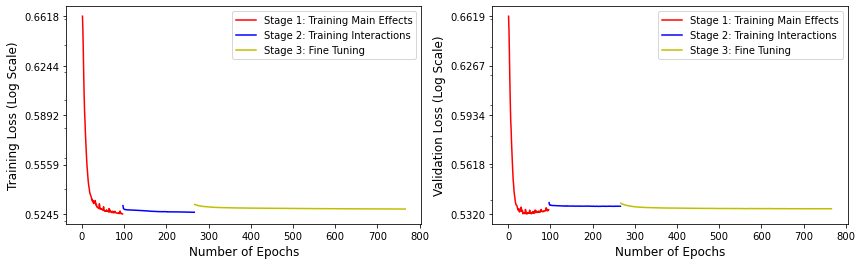

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


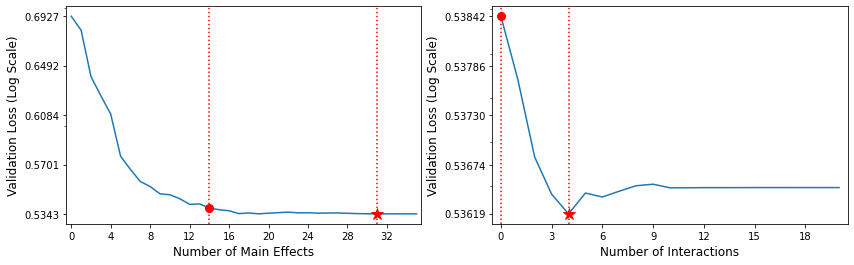

In [6]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)

model_fico = GAMINet(meta_info={"X" + str(i + 1):item for i, item in enumerate(meta_info.values())}, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5, 
            batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, 
            lr_bp=[0.001, 0.001, 0.0001], early_stop_thres=[50, 50, 50],
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            mono_increasing_list=[0, 1, 2, 3, 4, 7, 8, 9, 10, 14],
            mono_decreasing_list=[5, 6, 12, 15, 16, 17, 18, 21],
            verbose=True, val_ratio=0.2, random_state=0)
model_fico.fit(train_x, train_y)
data_dict_logs = model_fico.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="fico_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="fico_regu", save_png=True, save_eps=True)

In [7]:
pred_train = model_fico.predict(train_x)
pred_test = model_fico.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.81375 0.80842]


In [8]:
gaminet_stat = np.hstack([np.round(np.mean(train_y == (pred_train > 0.5)),5),
                          np.round(np.mean(test_y == (pred_test > 0.5)),5)])
print(gaminet_stat)

[0.74671 0.73873]


Global Interpretation

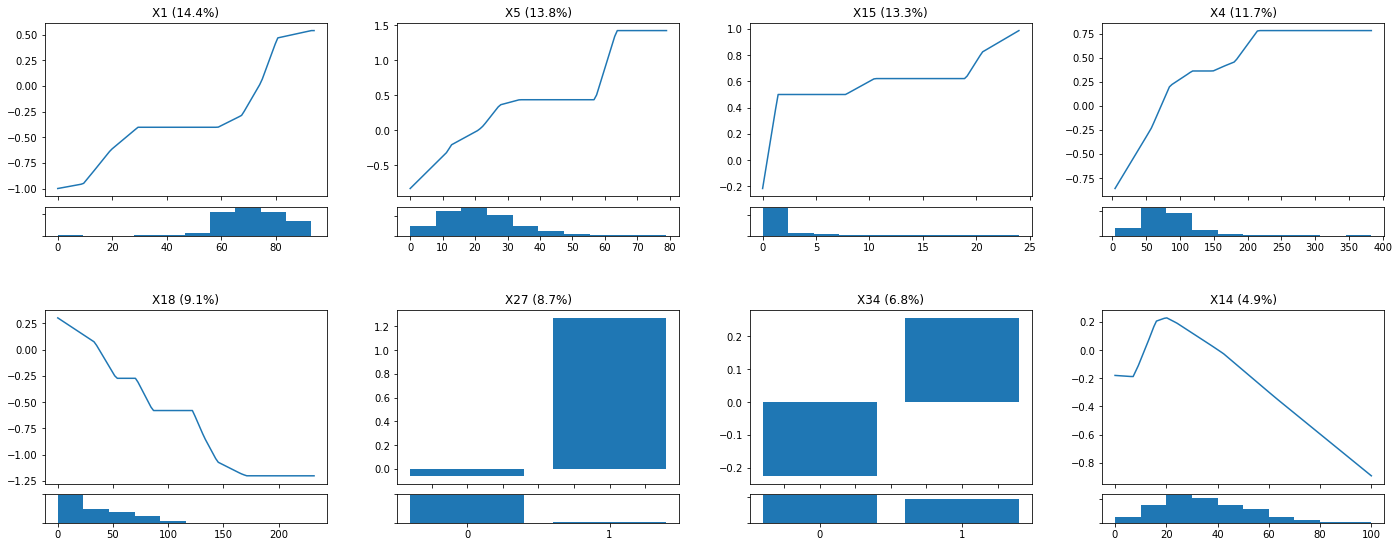

In [9]:
data_dict_global = model_fico.global_explain(save_dict=True, folder=folder, name="fico_global")
global_visualize_density(data_dict_global, folder=folder, name="fico_global",  #11, 13, 19, 20
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

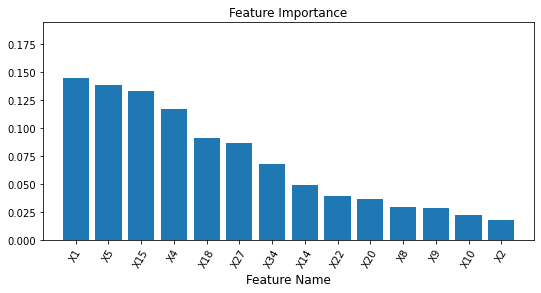

In [10]:
feature_importance_visualize(data_dict_global)

Interpret the prediction of a test sample

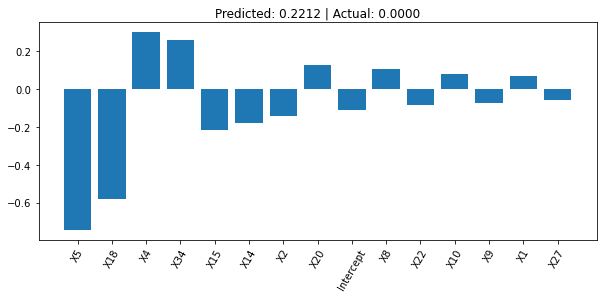

In [11]:
data_dict_local = model_fico.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)